In [9]:
import os
import requests
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import contextily as ctx
import sqlite3 as sl
from shapely.geometry import Point, Polygon, MultiPolygon
from shapely import wkt
from datetime import datetime

from bing_helper import Bing

from dotenv import load_dotenv

load_dotenv()

True

In [51]:
import requests
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import contextily as ctx
import sqlite3 as sl
from shapely.geometry import Point, Polygon, MultiPolygon
from shapely import wkt
from datetime import datetime
import logging

class Bing:
    """Facilitates interaction with Bing API Key"""
    
    def __init__(self, api_key, sqlite_path = 'cache.db'): 
        self.api_key = api_key
        self.sqlite_path = sqlite_path
        
        self.con = sl.connect(sqlite_path)
        with self.con:
            self.con.execute("""
                CREATE TABLE IF NOT EXISTS isochrone (
                    id       INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT,
                    uid      TEXT NOT NULL UNIQUE,
                    tt_mnts  INTEGER NOT NULL,
                    dep_dt   TIMESTAMP NOT NULL,
                    mode     TEXT NOT NULL,
                    geometry BLOB NOT NULL
                );
            """)
        logging.debug(f'Started new Bing object with key {self.api_key[:10]}...')
    
    def _check_cache(self, uid, tt_mnts, dep_dt, mode):
        """Reads cache with polygons in a SQLite database."""
        
        with self.con:
            data = self.con.execute(f"""
                SELECT * FROM isochrone 
                WHERE uid=? AND tt_mnts=? AND dep_dt=? AND mode=?
            """, (uid, tt_mnts, dep_dt, mode))

        record = data.fetchone()
        
        if record is None:
            return None
        else:
            return gpd.GeoSeries(wkt.loads(record[5])).set_crs("EPSG:4326")
        
    def _check_caches(self, ID_HDC_G0, uids):
        """Reads cache with polygons in a SQLite database."""
        
        assert isinstance(uids, pd.DataFrame)
        uids = uids.set_index('uid')
        
        with self.con:
            qry = f"SELECT * FROM isochrone WHERE uid LIKE '{city.ID_HDC_G0}%'; "
            result = uids.merge(pd.read_sql_query(qry, self.con), how='inner', on='uid')
            result['geometry'] = result['geometry'].apply(lambda x: wkt.loads(x))
            result = gpd.GeoDataFrame(result, crs="EPSG:4326")
            
        return result
            
    def _save_cache(self, uid, tt_mnts, dep_dt, mode, polygon):
        """Saves cache with multipolygon in a SQLite database."""
        try:
            with self.con:
                sql = """
                    INSERT INTO isochrone (uid, tt_mnts, dep_dt, mode, geometry) 
                    values(?, ?, ?, ?, ?)
                """
                result = self.con.execute(sql, (uid, tt_mnts, dep_dt, mode, polygon.iloc[0].wkt))
        except sl.IntegrityError:
            raise sl.IntegrityError("Please make sure the UID is unique.")
        
        return result
        
    
    def get_isochrone(self, startpt, uid, tt_mnts, dep_dt, mode, buf_m=0):
        """
        Gets isochrones from Bing Maps for a specific point. 
        :param starpt    A Shapely point which is the origin.
        :param uid       Unique location ID for saving in the caching database.
        :param tt_mnts   Maximum travel time
        :param dep_dt    Departure datetime object.
        :param mode      Travel mode in [driving, walking, transit]
        :param buf_m     [Optional] Amount of padding in polygon in meters.
        :return          Reachable areas in format MultiPolygon.
        """
            
        # Input checks
        global response
        assert isinstance(startpt, Point)
        assert isinstance(dep_dt, datetime)
        assert isinstance(tt_mnts, int)
        assert isinstance(uid, str)
        assert tt_mnts >= 5
        assert tt_mnts <= 45
        assert mode in ['driving', 'walking', 'transit']
        assert buf_m >= 0
        assert isinstance(tt_mnts, int)
        
        # Optimise for best result at departure time.
        if mode == 'driving':
            optimise = 'timeWithTraffic'
        else:
            optimise = 'time'
            
        # Format date string.
        dep_dt_str = dep_dt.strftime("%d/%m/%Y %H:%M:%S")
        
        # Check cache
        result = self._check_cache(uid, tt_mnts, dep_dt, mode)
        
        # Fetch if not cached
        if result is None:            
            # Fetch polygon from Bing Maps
            params = {
                'waypoint': f"{startpt.y},{startpt.x}", # LatLng
                'maxtime': tt_mnts,
                'timeUnit': 'minute',
                'distanceUnit': 'kilometer',
                'optimise': optimise,
                'datetime': dep_dt_str, # Example: 03/01/2011 05:42:00
                'travelMode': mode,
                'key': self.api_key
            }
            endpoint = 'https://dev.virtualearth.net/REST/v1/Routes/Isochrones'
            response = requests.get(endpoint, params=params)
            response_json = response.json()
            logging.debug(response_json)

            # Extract polygons to MultiPolygon
            polygons = []
            if len(response_json['resourceSets']) == 0: 
                logging.warning(f"No resourceSets found for this coordinate: {startpt.y},{startpt.x}")
            else:
                for l1 in response_json['resourceSets'][0]['resources'][0]['polygons']:
                    for l2 in l1['coordinates']:
                        polygons.append(Polygon([[e[1], e[0]] for e in l2]))
            result = gpd.GeoSeries(MultiPolygon(polygons)).set_crs("EPSG:4326")
            
            self._save_cache(uid, tt_mnts, dep_dt, mode, result)
            
        # Add padding as per requirement
        if buf_m > 0:
            result = result.to_crs(result.estimate_utm_crs())
            result = result.buffer(buf_m)
            result = result.to_crs("EPSG:4326")
        
        return result
    
    def get_isochrones_async(self, city_id, batch_list, buf_m=0, tqdm=True):
        """
        Gets isochrones from Bing Maps for a specific point. 
        :ID_HDC_G0       City to be searched.
        :batch_list      Iter with each [(starpt, uid, tt_mnts, (mode, dep_dt))]
        :param buf_m     [Optional] Amount of padding in polygon in meters.
        :param tqdm      [Optional] Show loading indicator of the points.
        
        Param batch_list is subject to the following:
        :param starpt    A Shapely point which is the origin.
        :param uid       Unique location ID for saving in the caching database.
        :param tt_mnts   Maximum travel time
        :param mode      Travel mode in [driving, walking, transit]
        :param dep_dt    Departure datetime object.
        :return          Reachable areas in row in format MultiPolygon.
        """
            
        # Input checks
        global response
        for (pid, startpt), tt_mnts, (mode, modetime, dep_dt) in batch_list:
            assert isinstance(startpt, Point)
            assert isinstance(dep_dt, datetime)
            assert isinstance(tt_mnts, int)
            assert tt_mnts >= 5
            assert tt_mnts <= 45
            assert mode in ['driving', 'walking', 'transit']
            assert isinstance(tt_mnts, int)
        assert buf_m >= 0
        
        # Generate combinations with ((pid,point), (mode/modetime/date), minutes, uid).
        uids = [ f"""{city.ID_HDC_G0}-{els[0][0]}-{els[2][1]}-{els[1]}m-v0"""
                 for els in list(batch_list) ]
        
        # Check caches
        
        uids = pd.DataFrame(uids)
        print(uids.head(10))
        
        
        qry = f"SELECT * FROM isochrones WHERE uid LIKE {city.ID_HDC_G0}% "
        uids.merge(pd.from_sql(qry, self.con), how='left', on='uid')
        
        
        return;
    
        # Optimise for best result at departure time.
        if mode == 'driving':
            optimise = 'timeWithTraffic'
        else:
            optimise = 'time'
            
        # Format date string.
        dep_dt_str = dep_dt.strftime("%d/%m/%Y %H:%M:%S")
        
        # Check cache
        result = self._check_cache(uid, tt_mnts, dep_dt, mode)
        
        # Fetch if not cached
        if result is None:            
            # Fetch polygon from Bing Maps
            params = {
                'waypoint': f"{startpt.y},{startpt.x}", # LatLng
                'maxtime': tt_mnts,
                'timeUnit': 'minute',
                'distanceUnit': 'kilometer',
                'optimise': optimise,
                'datetime': dep_dt_str, # Example: 03/01/2011 05:42:00
                'travelMode': mode,
                'key': self.api_key
            }
            endpoint = 'https://dev.virtualearth.net/REST/v1/Routes/Isochrones'
            response = requests.get(endpoint, params=params)
            response_json = response.json()
            logging.debug(response_json)

            # Extract polygons to MultiPolygon
            polygons = []
            if len(response_json['resourceSets']) == 0: 
                logging.warning(f"No resourceSets found for {mode} this coordinate: {startpt.y},{startpt.x}")
            else:
                for l1 in response_json['resourceSets'][0]['resources'][0]['polygons']:
                    for l2 in l1['coordinates']:
                        polygons.append(Polygon([[e[1], e[0]] for e in l2]))
            result = gpd.GeoSeries(MultiPolygon(polygons)).set_crs("EPSG:4326")
            
            self._save_cache(uid, tt_mnts, dep_dt, mode, result)
            
        # Add padding as per requirement
        if buf_m > 0:
            result = result.to_crs(result.estimate_utm_crs())
            result = result.buffer(buf_m)
            result = result.to_crs("EPSG:4326")
        
        return result

In [52]:
import itertools
import numpy as np

DROOT = '../1-data/'
KEY = os.environ['BING_API_KEY']
cities = pd.read_excel(os.path.join(DROOT, '1-research', 'cities.xlsx'), index_col=0)
cities.head(5)

CACHE_PATH = 'tmp.db'
KEY = os.environ['BING_API_KEY']
client = Bing(KEY, CACHE_PATH)

for i, city in cities.iterrows():
    file = f'{city.ID_HDC_G0}.pcl'
    df = pd.read_pickle(os.path.join(DROOT, '3-interim', 'populationmasks', file))
    gdf = gpd.GeoDataFrame(df)
    
    origins  = enumerate(gdf.centroid.to_crs("EPSG:4326"))
    times    = range(5, 55, 10)
    modes_dt = [('driving', 'driving-peak', datetime(2023, 5, 2, 8, 30, 37)), 
                ('driving', 'driving',      datetime(2023, 5, 2, 13, 0, 37)), 
                ('transit', 'transit-peak', datetime(2023, 5, 2, 8, 30, 37)),
                ('transit', 'transit',      datetime(2023, 5, 2, 13, 0, 37)), 
                ('walking', 'walking',      datetime(2023, 5, 2, 8, 30, 37))]
    
    batch_list = list(itertools.product(origins, times, modes_dt))

    # Generate combinations with ((pid,point), (mode/modetime/date), minutes, uid).
    uids = [ f"""{city.ID_HDC_G0}-{els[0][0]}-{els[2][1]}-{els[1]}m-v0"""
             for els in list(batch_list) ]

    # Check caches

    uids = pd.DataFrame(uids, columns=['uid'])

    output = client._check_caches(city.ID_HDC_G0, uids)
#     qry = f"SELECT * FROM isochrone WHERE uid LIKE '{city.ID_HDC_G0}%';"
#     output = uids.merge(pd.read_sql_query(qry, client.con), how='inner', on='uid')
    
    
#     combs = list(itertools.product(origins, times, modes_dt))
#     from_cache = client.get_isochrones_async(city.ID_HDC_G0, batch_list)
    
    break

,uid,id,tt_mnts,dep_dt,mode,geometry
0,3027-0-driving-peak-5m-v0,1,5,2023-05-09 08:30:00,driving,"MULTIPOLYGON (((16.26915 48.32819, 16.26970 48..."
1,3027-0-transit-peak-5m-v0,2088,5,2023-05-09 08:30:00,transit,MULTIPOLYGON EMPTY
2,3027-0-walking-5m-v0,2089,5,2023-05-09 08:30:00,walking,"MULTIPOLYGON (((16.30434 48.31247, 16.30462 48..."
3,3027-0-driving-peak-15m-v0,2,15,2023-05-09 08:30:00,driving,"MULTIPOLYGON (((16.18782 48.32427, 16.18944 48..."
4,3027-0-transit-peak-15m-v0,2090,15,2023-05-09 08:30:00,transit,"MULTIPOLYGON (((16.27794 48.32611, 16.27886 48..."
5,3027-0-walking-15m-v0,2091,15,2023-05-09 08:30:00,walking,"MULTIPOLYGON (((16.29472 48.31536, 16.29504 48..."
6,3027-0-driving-peak-25m-v0,3,25,2023-05-09 08:30:00,driving,"MULTIPOLYGON (((16.06068 48.31561, 16.06355 48..."
7,3027-0-transit-peak-25m-v0,2092,25,2023-05-09 08:30:00,transit,"MULTIPOLYGON (((16.33248 48.30213, 16.33340 48..."
8,3027-0-walking-25m-v0,2093,25,2023-05-09 08:30:00,walking,"MULTIPOLYGON (((16.28538 48.31866, 16.28568 48..."
9,3027-0-driving-peak-35m-v0,4,35,2023-05-09 08:30:00,driving,"MULTIPOLYGON (((15.90942 48.29008, 15.91177 48..."


In [ ]:
    for pid, point in tqdm(enumerate(origins), total=len(origins)):
        for i, t in enumerate(range(5, 55, 10)):
            uid = f'{city.ID_HDC_G0}-{pid}-driving-peak-{t}m-v0'
            client.get_isochrone(point, uid, t, STARTDATE, 'driving')

/Users/ivo/opt/anaconda3/envs/DUTTv2/lib/python3.11/site-packages/geopandas/array.py:938: RuntimeWarning: All-NaN slice encountered
  np.nanmin(b[:, 0]),  # minx
/Users/ivo/opt/anaconda3/envs/DUTTv2/lib/python3.11/site-packages/geopandas/array.py:939: RuntimeWarning: All-NaN slice encountered
  np.nanmin(b[:, 1]),  # miny
/Users/ivo/opt/anaconda3/envs/DUTTv2/lib/python3.11/site-packages/geopandas/array.py:940: RuntimeWarning: All-NaN slice encountered
  np.nanmax(b[:, 2]),  # maxx
/Users/ivo/opt/anaconda3/envs/DUTTv2/lib/python3.11/site-packages/geopandas/array.py:941: RuntimeWarning: All-NaN slice encountered
  np.nanmax(b[:, 3]),  # maxy


ValueError: NaN or None values are not allowed.

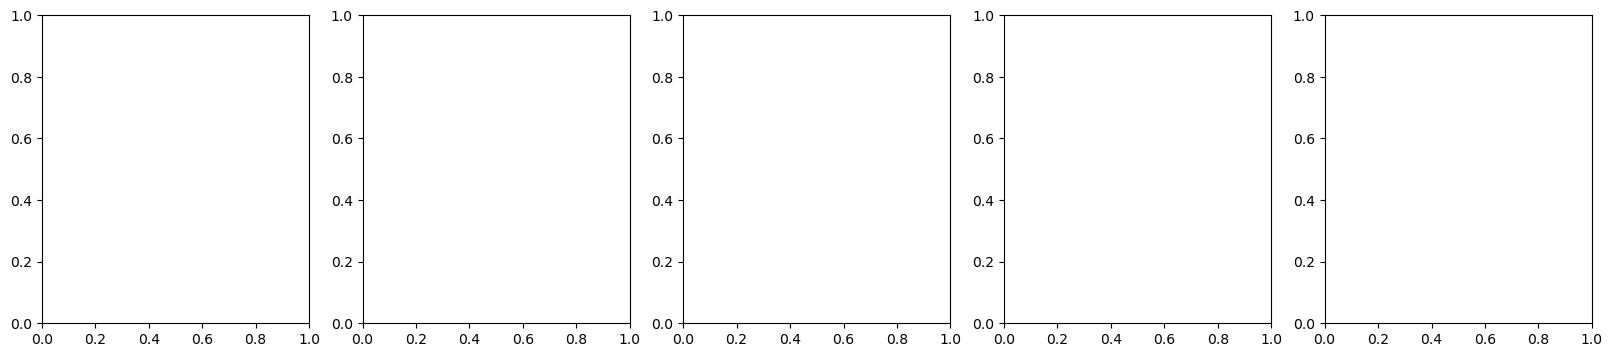

In [3]:
STARTDATE = datetime(2023, 5, 2, 16, 0, 37)
STADSHUSET = Point(18.0547751, 59.327560)
CACHE_PATH = 'tmp.db'
KEY = os.environ['BING_API_KEY']

client = Bing(KEY, CACHE_PATH)

fig, axs = plt.subplots(ncols=5, figsize=(20, 4))
for i, t in enumerate(range(5, 55, 10)):
    stockholm = client.get_isochrone(STADSHUSET, f'trial-{t}', t, STARTDATE, 'transit', buf_m=50)
    stockholm.plot(ax=axs[i])